## Machine Learning I / Mini Lab Predictive Analysis
<b>Authors:</b> Fabio Savorgnon, Tina Pai, Paritosh Rai, Ellen Lull
<br><b>Data set from:</b> https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

After our initial Exploratory Data Analysis (EDA) project, we needed to pick a model that would predict if a patient would have cardiovascular disease based on the variables available in our data.  These are:  gender, systolic blood pressure, diastolic blood pressure, age, height and weight (which we used to calculate Body Mass Index or BMI), a cholesterol level indicator, a glucose level indicator, and indicators to identify if a patient used alcohol, smoked or was active.    You can view the full descriptions of these data elements in our EDA document.
<br>  

During our EDA, we determined that the factors that had the highest level of correlation to cardiovascular disease were:   Blood pressure, BMI, Age, Cholesterol and Glucose.     However, we didn’t want to limit ourselves to only these.   So, we ran five combinations of the variables.  For each combination of variables, we ran both SVM and Logistical Regression models.  For each combination and method, we ran with scaled data and non-scaled data.   Our findings are documented below.


# Setup


In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV


df = pd.read_csv("cardio_train.csv", sep=";")



# Clean data
Removing invalid values per our Exploratory Data Analysis document

This data has values for weight, height and blood pressure that are not possible for living people.  We decided that these were errors and are removing them.

Body Mass Index (BMI) and Blood Pressure ranges are calculated.   See our EDA document for in depth analysis


### Weight and Height Clean-up

In [25]:

# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]


### Blood Pressure Clean-Up and categories

In [26]:

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

# bin blood pressure groups based on the api hi/ lo variables
# bp is 1 - 5 where 1 is Normal, 2 is Elevated, 3 is HyperTension Stage1, 4 is HyperTensions Stage2, 5 is Hypertension Stage3
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)
df['bp1'] = pd.cut(df.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3'])





### Calculate BMI (Body Mass Index)

In [27]:
# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2

In [28]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bp,bp1,bmi
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,4,Hyper_Stage2,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,3,Hyper_Stage1,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,4,Hyper_Stage2,28.710479
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,3,Hyper_Stage1,29.384676
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,3,Hyper_Stage1,37.729725


# Model Variable Selection Options

The following combinations of variables were used in our analysis.   We ran models for each of these combinations of variables and selected a primary model and a secodary model.    The siginficant model analysis is listed below.   The analysis of the less accurate models is placed in the appendix of this document.  We are referring to these as Options 1-5

**Option 1:** bmi, ap_hi, ap_lo_cholesterol, age  (top 5 in correlation to cardio response variable)


**Option 2:** ap_hi  (highest correlation to response)


**Option 3:** bmi,  age, ap_lo, ap_hi,  cholesterol', gluc , smoke , alco , active  (all variables except gender and id)

**Option 4:** weight,  age,  ap_lo, ap_hi,  cholesterol (significant variables replacing BMI with weight.  Height is excluded since the correlation is low)

**Option 5:** bmi, age, bp, cholesterol (high correlation, removing collinear variables)




## Summary of Model Analysis
##### The following is the summary of Analysis that was run on Logistic Regression and SVM with Five options in unscaled and scaled options.

The chart below shows the comparison of all models we ran on AUC score.   We are showing the results of the more significant models in the main body of this notebook, and have included the models of less interest in the Appendix.

We compared all models both with and without scaling the data.  

The highest performing model for Logistic Regression, per AUC, was Option 3, which included all variables.   A very close score was obtained for Option 1, which included: Body Mass Index, Systolic Blood Pressure, Diastolic Blood pressure, Cholesterol and Age.   Since these Option 1 variables were our most significant variables per our Exploratory Data Analysis, we chose Option 1 as our preferred model.  For these Logistical Regression models, a scaling option was reviewed.  However, scaling the data did not improve the performance of the model.

The highest performing model for SVM was option 1 with the variables described above.   In this case, scaling the data did make a difference.

Our primary model is Logistic Regression, unscaled data with the following attributes: Body Mass Index, Systolic Blood Pressure, Diastolic Blood pressure, Cholesterol and Age.

Our backup/ secondary model is SVM with scaled data and the following attributes: Body Mass Index, Systolic Blood Pressure, Diastolic Blood pressure, Cholesterol and Age.

### Comparison of models on AUC score, F1 Score and Accuracy Score:
The team reviewed models based on Area Under Curver (AUC), F1 Score, Accuracy.   We decided to use AUC as our final deciding factor for the variables and parameters of the model.  We then further tuned the models to get the best F1 score.  We chose the F1 score as a metric to show a good balance between precision and recall.    We also looked at the Acccuracy score of the models.

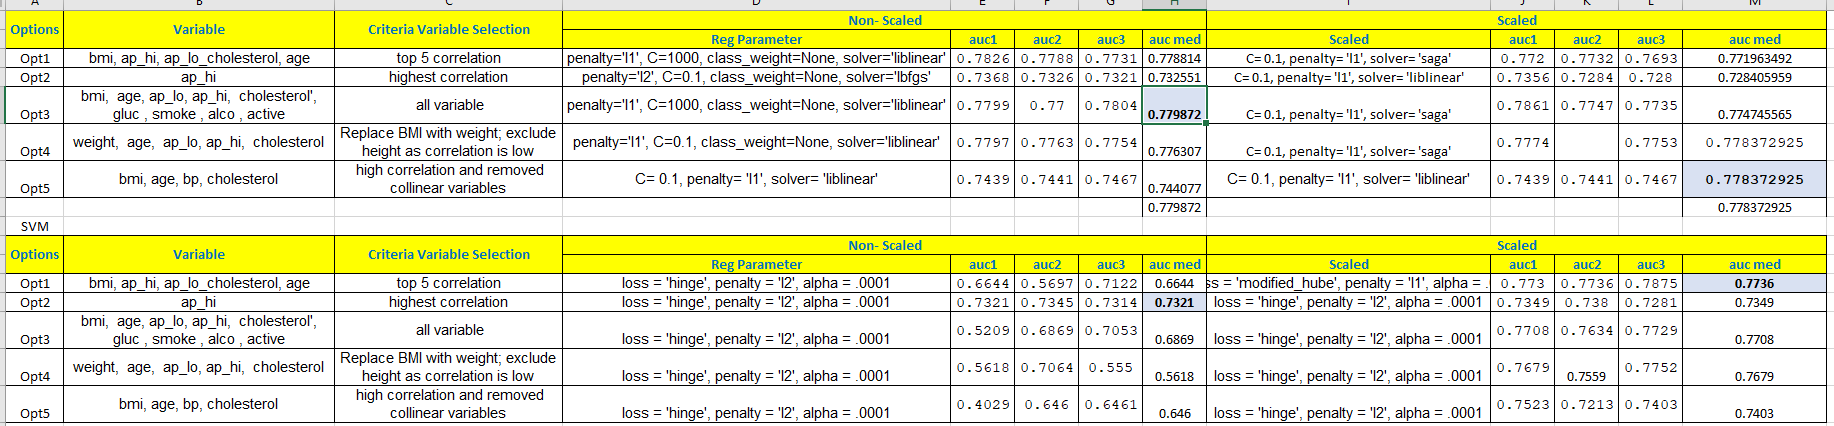

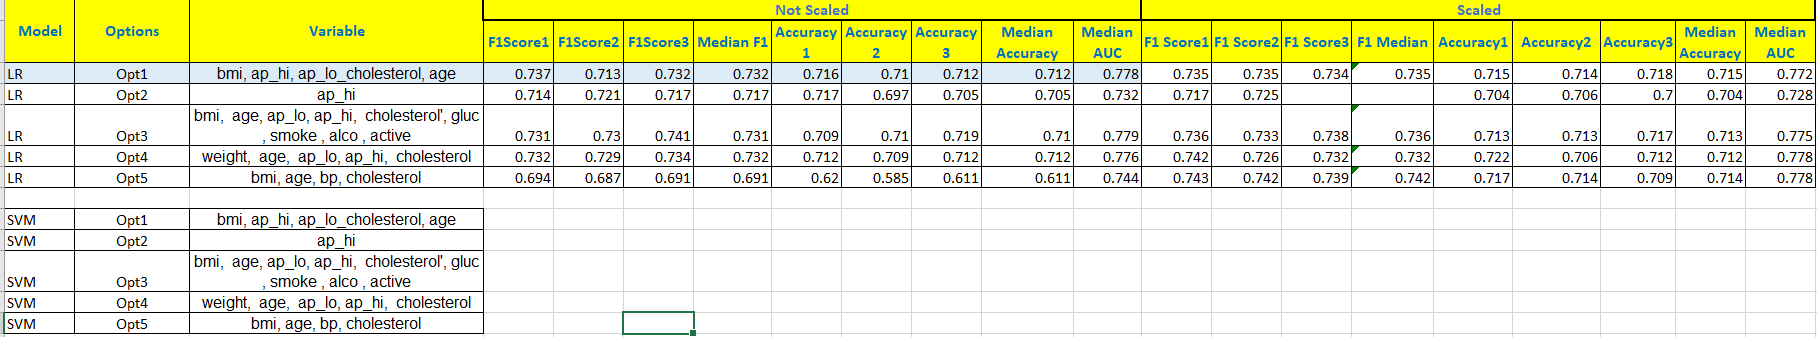
 

### Add AUC for decision tree/random forest to above chart
## Add chart for Confusion matrix

# Beginning of Model Analysis

First we will show our Logistical Regression Analysis, since that resulted in our preferred model.   Then we will describe our SVM analysis since that gave us our secondary model

We also ran Decision Tree and Random Forest Models.   They gave us much lower AUC scores, so we rejected them as well

### Logistic Regression

 There are multiple parameters that can help build a Logistic  Regression model listed below with the default value.  


*(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None])*



However, our team decided to focus on few critical in tuning process like C, solver and penalty. 



Hyperparameters sets the algorithm that can be adjusted to optimize performance, these are the knobs to generate optimal outcome. These Hyperparameters in machine learning model help define your model architecture. Leveraging grid search optimal automated exploration is launched to find the optimal parameter value to extract best model architecture. 

The project Grid search approach was used to tune the parameters of the model. Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. However, grid search suffers from the curse of dimensionality: the number of times required to evaluate the model during hyperparameter optimization grows exponentially in the number of parameters. 

The other popular method is Random Search. It is performed by evaluating n uniformly random points in the hyperparameter space and select the one producing the best performance. The drawback of random search is unnecessarily high variance. The method is, after all, entirely random, and uses no intelligence in selecting which points to try. You are relying on luck to get good results.

In the model building excises Grid Search was used and to overcome the curse of dimensionality hyper parameter list was highly evaluated and one making maxim impact were chosen. The model tuning process three parameters were considered, C, penalty and Solver. 

<b>C:</b> This control the complexity and simplicity of model. However, complexity can lead to over fitting vs. simplicity will lead to under fitting. Small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C the power of regularization is decrease which impels the model is allowed to increase it's complexity, and therefore, overfit the data. 

<b>Penalty:</b> This project uses two penalties. L1 and L2. The Penalty is used to specify the penalization method of the coefficients of noncontributing or less contributing variables.
Lasso (L1) performs feature selection by shrinking the less important feature’s coefficient to zero.
Ridge (L2) all variables are included in the model, though some are shrunk (but not to zero like L1 Penalty. Less computationally intensive than lasso.
Both penalty values restrict solver choices. It is critical to choose the right combination of Penalty.



<b>Solver:</b> Are the algorithm used in Logistic Regression to predict the outcome. Default value is lbfgs. other possible values (to list few) are, liblinear, sag and saga.
liblinear − It is a good choice for small datasets. It also handles L1 penalty. For multiclass problems, it is limited to one-versus-rest schemes.
lbfgs − For multiclass problems, it handles multinomial loss. It also handles only L2 penalty.
saga − It is a good choice for large datasets. For multiclass problems, it also handles multinomial loss. Along with L1 penalty, it also supports ‘elasticnet’ penalty.
sag − It is also used for large datasets. For multiclass problems, it also handles multinomial loss.



<b>Ref:</b> 
https://sigopt.com/blog/common-problems-in-hyperparameter-optimization

https://towardsdatascience.com/hyper-parameter-tuning-and-model-selection-like-a-movie-star-a884b8ee8d





### Option 1 model

Option 1 was a model using the following variables: bmi, ap_hi, ap_lo_cholesterol, age
<br> These had the highest correlation to the cardio response variable</b>

This model became our preferred model

In [29]:
#df
# option 1'bmi', 'ap_hi', 'ap_lo','cholesterol','age'
y = df['cardio'].values # get the labels we want
X = df[['bmi', 'ap_hi', 'ap_lo','cholesterol','age']].values 

In [30]:
#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Hyper Parameter Tuning      This is for Non-Scaled Data

Run Option 1 model with Non- Scaled data.   We scale the data and run it again below

In [31]:
#make a grid search for logistic regression


param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)



GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l2'],
                          'solver': ['lbfgs']}],
    

In [32]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.777471 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.777471 (0.002128) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.777377 (0.002105) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.777364 (0.002160) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.777398 (0.002107) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.777424 (0.002130) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.631834 (0.018415) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.631829 (0.018409) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.631831 (0.018411) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.631829 (0.018409) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.631830 (0.018409) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [33]:
lr_clf = LogisticRegression(penalty='l1', C=1000, class_weight=None, solver='liblinear' ) # get object


### Metrics for Option 1 Logistical Regression Model with Non-Scaled Data

In [34]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
  
    # Show the F1 Score
    fscore = mt.f1_score(y_test,y_hat)
    print("F1 Score: ", fscore)
    
    # Show the Accuracy Score
    acc = mt.accuracy_score(y_test,y_hat)
    print("accuracy", acc )
    
    # Show the Classification Matrix
    print(mt.classification_report(y_test,y_hat))
    
    iter_num+=1

====Iteration 0  ====
auc 0.7795568398334853
confusion matrix
 [[3344 1281]
 [1747 4239]]
F1 Score:  0.7368329567182339
accuracy 0.7146357553482235
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      4625
           1       0.77      0.71      0.74      5986

    accuracy                           0.71     10611
   macro avg       0.71      0.72      0.71     10611
weighted avg       0.72      0.71      0.72     10611

====Iteration 1  ====
auc 0.7707292495292384
confusion matrix
 [[3323 1337]
 [1707 4244]]
F1 Score:  0.7360388484217829
accuracy 0.713127886155876
              precision    recall  f1-score   support

           0       0.66      0.71      0.69      4660
           1       0.76      0.71      0.74      5951

    accuracy                           0.71     10611
   macro avg       0.71      0.71      0.71     10611
weighted avg       0.72      0.71      0.71     10611

====Iteration 2  ====
auc 0.7829192311572999
confus


## Analysis of F1 Score and Accuracy

The F1 score for this model is .74.   The F1 score is a harmonic mean of precision and recall.  It is calculated from the precision and recall of the test. Precision represents the number of correctly identified positive results divided by the number of all positive results.   Recall represents the number of correctly identified positive results divided by the number of all samples that should have been identified as positive.   


Accuracy score for this model is .72.  This represents the number of correctly identified true positives and true negatives.


While this reinforced our belief that the model was accurate, we used the AUC score to make our final determination of our preferred model because it displays the relationship between sensitivity and specificity.   We picked the AUC as the metric for comparing the effectiveness of our models because AUC represents a model's potential for maximizing true positives and minimizing false negatives. 

### Logistic Regression Option 1 Redo Test/Train split for Scaled Data

In [35]:
#make CV spit 80/20 object
 
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

### Option 1 Logistic Regression Hyper Parameter Tuning      This is for Scaled Data

In [36]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


#clf.cv_results_



GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                       

In [37]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.773888 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.773887 (0.002583) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.773888 (0.002583) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.773882 (0.002583) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.773882 (0.002584) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.773882 (0.002583) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.773881 (0.002583) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.773881 (0.002583) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.773881 (0.002583) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.773881 (0.002584)

### Metrics for Option 1 Logistical Regression Model with Scaled Data

In [38]:
lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)

0.7828382244836185
[0.71501272 0.7181227  0.71331637]


In [39]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
          
    # Show the F1 Score
    fscore = mt.f1_score(y_test,y_hat)
    print("F1 Score: ", fscore)
    
    # Show the Accuracy Score
    acc = mt.accuracy_score(y_test,y_hat)
    print("accuracy", acc )
    
    # Show the Classification Matrix
    print(mt.classification_report(y_test,y_hat))
    
    iter_num+=1

====Iteration 0  ====
auc 0.7753377419890934
confusion matrix
 [[3433 1233]
 [1762 4183]]
F1 Score:  0.7363788398908546
accuracy 0.7177457355574404
              precision    recall  f1-score   support

           0       0.66      0.74      0.70      4666
           1       0.77      0.70      0.74      5945

    accuracy                           0.72     10611
   macro avg       0.72      0.72      0.72     10611
weighted avg       0.72      0.72      0.72     10611

====Iteration 1  ====
auc 0.7781439114431127
confusion matrix
 [[3344 1282]
 [1750 4235]]
F1 Score:  0.7363936706659711
accuracy 0.7142587880501367
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      4626
           1       0.77      0.71      0.74      5985

    accuracy                           0.71     10611
   macro avg       0.71      0.72      0.71     10611
weighted avg       0.72      0.71      0.72     10611

====Iteration 2  ====
auc 0.7721167018864619
confu

In [56]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""


"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [57]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [58]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [59]:
model=clf.best_estimator_.fit(X,y)

In [60]:
model.named_steps["classifier"].coef_

array([[0.10076592, 0.89572666, 0.12865128, 0.28285413, 0.29728539]])

##  Preferred Model Logistical Regression Option 1 Analysis Continued

## Interpretation of the weights   Logistical Regression Option 1

In [61]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

AttributeError: 'Pipeline' object has no attribute 'coef_'

## Graph of the weight

In [ ]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')
plt.show()

You can see how the selection of the variables for the logistic regression gives us three stable models in the training split with accuracy result of 71.3%, 71.1 %, and 70.8 %.The accuracy can be defined as the percentage of correctly classified instances (TP + TN)/(TP + TN + FP + FN) 
It also give us a stable AUC of 0.774, 0.777 and 0,773. Sensitivity versus 1- Specificity curve which is shown below.
As you can see in the graphic above cholesterol has the highest weight to predic a cardiac event, it has a weight of 0.409. It is followed by blood pressure (ap_hi), which has a weight of 0.06, and blood pressure(ap_lo), which has a weight of 0.014.The blood pressure high has more weight to predic a cardiac event than the low blood pressure. Also with less weight to predict cardiac event in relation to blood pressure high but slightly more than blood pressure low is the bmi, with a weight of 0.019. Finally with the lowest weight to predic cardiac events is the age with a weight of 0.0001.
The model also have a recall of 72% for no cardic event and 71% for cardic events.Precision of 65% for non cardioc events and 77% for cardic events. And the f1 score is calculated from the precision and recall of the test, where the precision is the number of correctly identified positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive.The F1 score is the harmonic mean of the precision and recall. The f1 score is 69% for non cardic events and 74% for cardioc events.

###  Option 1 Precision Recall Curve

In [ ]:
# roc curve and auc


lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Roc curve and auc

## Option 3 model    Logistical Regression
Option 3 is a model with all of the significant variables: bmi,  age, ap_lo, ap_hi,  cholesterol, gluc , smoke , alco , active.  It does not include ID and Gender


In [ ]:
y = df['cardio'].values # get the labels we want
X = df[['bmi','age','ap_lo','ap_hi','cholesterol','gluc','smoke','alco','active']].values 

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

### Logistic Regression  Option 3 Non-Scaled Data

In [ ]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)



In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Logistic Regression for Option 3

In [ ]:
#LogisticRegression(solver='lbfgs')
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object



In [ ]:
#make CV spit 80/20 object
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
print(cv_object)

In [ ]:
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object


### Metrics for Logistic Regression, Option 3 with Un-Scaled Data

In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
              
    # Show the F1 Score
    fscore = mt.f1_score(y_test,y_hat)
    print("F1 Score: ", fscore)
    
    # Show the Accuracy Score
    acc = mt.accuracy_score(y_test,y_hat)
    print("accuracy", acc )
    
    # Show the Classification Matrix
    print(mt.classification_report(y_test,y_hat))
    
    
    iter_num+=1

### Scaling

### Option 3 Logistic Regression with Scaled Data Train/Test Split

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

#### Logistic Regression Scaled

### Hyper Parameter Tuning for Option 3 Logisic Regression with Scaled data

In [ ]:
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_

In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Metrics for Option 3 Logistic Regression with Scaled Data

In [ ]:

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)

In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
              
    # Show the F1 Score
    fscore = mt.f1_score(y_test,y_hat)
    print("F1 Score: ", fscore)
    
    # Show the Accuracy Score
    acc = mt.accuracy_score(y_test,y_hat)
    print("accuracy", acc )
    
    # Show the Classification Matrix
    print(mt.classification_report(y_test,y_hat))
        
    iter_num+=1

In [ ]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

In [ ]:
model=clf.best_estimator_.fit(X,y)

In [ ]:
model.named_steps["classifier"].coef_

### Option 3, Logistic Regression.  Precision Recall Curve

In [ ]:
# roc curve and auc


lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# SVM Analysis

Using the same Variable combination options, we ran them through SVM models.   Below is a description of our most accurate models based on AUC score

In [ ]:
if 'cardio' in df:
    y = df['cardio'].values
    X = df[['bmi','age','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','bp']]

### SVM train/test split

In [ ]:
#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

## SVM Baseline model Option 2:  (ap_hi only)

### SVM Option 2 Not Scaled

In [ ]:
X = df[['ap_hi']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

### Scaled

In [ ]:
X = df[['ap_hi']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

## SVM using Option 1:  BMI, age, ap_hi, ap_lo, cholesterol

These are the variables which are most correlated to the response varaible.  It is Option 1 in our analysis chart

### Not Scaled Data - Option 1 SVM

In [ ]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

### Scaled Data - Option 1 SVM

In [ ]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

### Hyperparameter Tuning - Option 1 SVP

In [ ]:
from sklearn.model_selection import GridSearchCV

### SVM  Scaled

In [ ]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

param_grid = [
  {'classifier__loss': ['modified_huber'],
   'classifier__penalty': ['l1', 'l2', 'elasticnet'],
   'classifier__alpha': [.001, .01, .05, .1, .5, 1]}
 ]

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier())])

clf = GridSearchCV(svm, param_grid, scoring="roc_auc")
clf.fit(X, y)

In [ ]:
clf.best_params_

### Metrics for Option 1, SVM

In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best auc: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    


## Probability Calibration - SVM Option 1

In [ ]:
#https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
from sklearn.calibration import CalibratedClassifierCV

model = clf.best_estimator_ #this was alpha=.1, loss='modified_huber', penalty='elasticnet'
calibrator = CalibratedClassifierCV(model, cv=3)

aucs = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

## ROC  SVM Option 1

In [ ]:
# roc curve and auc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

std_scl = StandardScaler()
scl_obj = std_scl.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

model.fit(X_train, y_train)

# predict probabilities
svm_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
svm_auc = roc_auc_score(y_test, svm_probs)
# summarize scores\
print('SVM Model ROC AUC=%.3f' % (svm_auc))
# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
# plot the roc curve for the model
pyplot.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Find probability threshold for best accuracy

In [ ]:
svm_probs

In [ ]:
alphas = np.arange(0, 1, .1)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))



### tune a little finer

In [ ]:
alphas = np.arange(.4, .6, .01)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))



## Support Vector Analysis

In [ ]:
    
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']].values
cv_object =  ShuffleSplit(n_splits=1,
                         test_size  = 0.9)

#train test split
for train_indices, test_indices in cv_object.split(X, y):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    scl_obj = StandardScaler()
    scl_obj.fit(X_train)
    
    X_train_scaled = scl_obj.transform(X_train)
    X_test_scaled = scl_obj.transform(X_test) 
        

# train the model
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object
    
# make a dataframe of the training data
df_tested_on = df.iloc[train_indices].copy() # saved from above, the indices chosen for training

# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['cardio'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df['cardio'] = y # also add it back in for the original data
df_support.info()

### Plot SVM Vectors - Option 1

In [ ]:
# group the original data and the support vectors
df_grouped_support = df_support.groupby(['cardio'])
df_grouped = df.groupby(['cardio'])

# plot KDE of Different variables
 
vars_to_plot =['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']

for v in vars_to_plot:
    pyplot.figure(figsize=(10,4))
    # plot support vector stats
    pyplot.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    pyplot.legend(['noncardio','cardio'])
    pyplot.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    pyplot.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    pyplot.legend(['noncardio','cardio'])
    pyplot.title(v+' (Original)')




The graphs on the left show the support vectors which are the points on the SVM borders.  These are compared to the graphs on the right which show the distribution of the response variable classes. The above graphs show that the support vectors are distributed in a similar manner between the cardio and non-cardio classes of the response variable. The original distribution shows the uneven distribution of the response variable for each predictor.

# SVM

Our favorite SVM model is Option 1 Scaled

Confusion matrix / classification report  - Ellen

precision, recall, f1, accuracy - Ellen

explain the hyperparameters - Tina

### Interpretation

Make SVC from subsampled set - Tina

Ellen

# Logistic regression

Our favorite Logistic model is Option 1 Unscaled

Confusion matrix / classification report 

precision, recall, f1, accuracy

explain the hyperparameters - Paritosh, Fabio

## Interpretation of the weight 

In [ ]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

## Graph of the weight

In [ ]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')
plt.show()

You can see how the selection of the variablesfor the logistic regression gives us three stable model in the training split with accuracy result of 71.3%, 71.1 %, and 70.8 %.The accuracy can be defined as the percentage of correctly classified instances (TP + TN)/(TP + TN + FP + FN) 
It also give us a stable AUC of 0.774, 0.777 and 0,773. Sensitivity versus 1- Specificity curve which is showing below.
As you can see in the graphic above cholesterol has the highest weight to predic a cardiac event, it has a weight of 0.409. It is followed by blood pressure (ap_hi), which has a weight of 0.06, and blood pressure(ap_lo), which has a weight of 0.014.The blood pressure high has more weight to predic a cardiac event than the low blood pressure. Also with less weight to predict cardiac event in relation to blood pressure high but slightly more than blood pressure low is the bmi, with a weight of 0.019. Finally with the lowest weight to predic cardiac events is the age with a weight of 0.0001.
The model also have a recall of 72% for no cardic event and 71% for cardic events.Precision of 65% for non cardioc events and 77% for cardic events. And the f1 score is calculated from the precision and recall of the test, where the precision is the number of correctly identified positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive.The F1 score is the harmonic mean of the precision and recall. The f1 score is 69% for non cardic events and 74% for cardioc events.

## Roc curve and auc

In [ ]:
# roc curve and auc
lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Fabio

# Advantages and Disadvantages

Our favorite model overall is the Logistic regression option 1 unscaled.

Is one better about training time?

Is one better from accuracy?

# Appendix

In this section we have placed the remaining models from our chart above.   They were all determined to be less accurate and were rejected, but we placed them here to show a comparason of the different variable options for SVM and Logistic regression with scaled and unscaled data

## Decision Tree Model

In [ ]:
from sklearn.model_selection import train_test_split
X = df[['bmi', 'ap_hi', 'ap_lo','cholesterol','age']]
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [ ]:
"""#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)
"""

#### Training a Decision Tree Model
Let's start by training a single decision tree first!

** Import DecisionTreeClassifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data.

In [ ]:
dtree = DecisionTreeClassifier()

In [ ]:
dtree.fit(X_train,y_train)

#### Predictions and Evaluation of Decision Tree

Create predictions from the test set and create a classification report and a confusion matrix

In [ ]:
predictions = dtree.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:

from sklearn import metrics as mt
auc = mt.roc_auc_score(y_test,predictions)
print("auc", auc )

### Training the Random Forest model
Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=600)

In [ ]:
rfc.fit(X_train,y_train)

### Predictions and Evaluation
Let's predict off the y_test values and evaluate our model.

** Predict the class of not.fully.paid for the X_test data.**

In [ ]:
predictions = rfc.predict(X_test)

Now create a classification report from the results.

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(y_test,predictions))

## The following Logistical Regression Models were rejected, but they were not far in accuracy and AUC scores from the preferred model.

### Logistic Regression Option 2   AP_HI variable only (systolic blood pressure).  With unscaled data

In [ ]:
# option 2  systolic blood pressure
y = df['cardio'].values  
X = df['ap_hi'].values 
X = X.reshape(-1, 1)

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

### Logistic Regression - Option 2 Unscaled

In [ ]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs', 'sag', 'saga']},
 ]


lr = LogisticRegression(max_iter=4000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
 
clf.fit(X, y)


### Metrics for Option 2 Logistic Regression unscaled Data

In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
 
lr_clf = LogisticRegression(penalty='l2', C=0.1, class_weight=None, solver='lbfgs' ) # get object




In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    
          
    # Show the F1 Score
    fscore = mt.f1_score(y_test,y_hat)
    print("F1 Score: ", fscore)
    
    # Show the Accuracy Score
    acc = mt.accuracy_score(y_test,y_hat)
    print("accuracy", acc )
    
    # Show the Classification Matrix
    print(mt.classification_report(y_test,y_hat))
    
    iter_num+=1

### Option 2 Logistic Regression Scaled data:   train/test split

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

### Logistic Regression, Option 2 Hyper Parameter Tuning 

In [ ]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)




In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Metrics for Logistic Regression, Option 2 Scaled data

In [ ]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'liblinear'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    
     # Show the F1 Score
    fscore = mt.f1_score(y_test,y_hat)
    print("F1 Score: ", fscore)
    
    # Show the Accuracy Score
    acc = mt.accuracy_score(y_test,y_hat)
    print("accuracy", acc )
    
    # Show the Classification Matrix
    print(mt.classification_report(y_test,y_hat))
    
    iter_num+=1

In [ ]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

In [ ]:
model=clf.best_estimator_.fit(X,y)

In [ ]:
model.named_steps["classifier"].coef_

### Option 2 Logistic Regression : precision recall curve

In [ ]:
# roc curve and auc
lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()



## Option 4, Logistic Regression: weight,  age,  ap_lo, ap_hi,  cholesterol 

In [ ]:
y = df['cardio'].values # get the labels we want
X = df[['weight','age','ap_lo','ap_hi','cholesterol']].values

### Option 4  Logistic Regression Unscaled data model

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

### Option 4 Logistic Regression   Unscaled data

In [ ]:

from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Metrics for Logistic Regression Unscaled data Option 4

In [ ]:
#LogisticRegression(solver='lbfgs')
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object


In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    
    # Show the F1 Score
    fscore = mt.f1_score(y_test,y_hat)
    print("F1 Score: ", fscore)
    
    # Show the Accuracy Score
    acc = mt.accuracy_score(y_test,y_hat)
    print("accuracy", acc )
    
    # Show the Classification Matrix
    print(mt.classification_report(y_test,y_hat))
    
    iter_num+=1

### Logistic Regression Option 4 Scaled data train/test split

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

### Logistic Regression Scaled, Option 4 Hyper Parameter Tuning 

In [ ]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Metrics Option 4 Logistic Regression Scaled data

In [ ]:
lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    
     # Show the F1 Score
    fscore = mt.f1_score(y_test,y_hat)
    print("F1 Score: ", fscore)
    
    # Show the Accuracy Score
    acc = mt.accuracy_score(y_test,y_hat)
    print("accuracy", acc )
    
    # Show the Classification Matrix
    print(mt.classification_report(y_test,y_hat))
    
    iter_num+=1

In [ ]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

In [ ]:
model=clf.best_estimator_.fit(X,y)

In [ ]:
model.named_steps["classifier"].coef_

### Option 4 Logistic Regegression- precision recall curve

In [ ]:
# roc curve and auc

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()




## Logistic Regession Option 5   bmi, age, bp, cholesterol

In [ ]:
y = df['cardio'].values # get the labels we want
X = df[['bmi','age','bp','cholesterol']].values

In [ ]:
X

### Option 5 Logistic Regression Option 5 unscaled data model

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

### Option 5 Logistic Regression unscaled data

In [ ]:

from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)



### Metrics for Logistic Regression Option 5 Unscaled data

In [ ]:
LogisticRegression()
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object



### Metrics for Logistic Regression Option 5 Unscaled data

In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
        
     # Show the F1 Score
    fscore = mt.f1_score(y_test,y_hat)
    print("F1 Score: ", fscore)
    
    # Show the Accuracy Score
    acc = mt.accuracy_score(y_test,y_hat)
    print("accuracy", acc )
    
    # Show the Classification Matrix
    print(mt.classification_report(y_test,y_hat))
    
    iter_num+=1

### Option 5 Logistic Regression Scaled data train/test split

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

### Option 5 Logistic Regression Scaled Data Hyper Parameter Tuning 

In [ ]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)



In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Metrics for Logistic Regression Option 5 Scaled Data

In [ ]:
lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'liblinear'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    
     # Show the F1 Score
    fscore = mt.f1_score(y_test,y_hat)
    print("F1 Score: ", fscore)
    
    # Show the Accuracy Score
    acc = mt.accuracy_score(y_test,y_hat)
    print("accuracy", acc )
    
    # Show the Classification Matrix
    print(mt.classification_report(y_test,y_hat))
        
    iter_num+=1

In [ ]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

In [ ]:
model=clf.best_estimator_.fit(X,y)

In [ ]:
model.named_steps["classifier"].coef_

### Logistic Regression Option 5 precision recall curve

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# SVM Models that were rejected

##  SVM Option 3:   All Sigificant Variables: bmi,  age, ap_lo, ap_hi, cholesterol, gluc, smoke, alco, active

### Option 3 SVM Not Scaled

In [ ]:
X = df[['bmi', 'age', 'ap_lo', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'weight']]

svm_clf = Pipeline(steps=[    
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

### Option 3 SVM Scaled

In [ ]:
X = df[['bmi', 'age', 'ap_lo', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'weight']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

### Option 3 SVM Hyperparameter Tuning

### Option 3 SVM Unscaled

In [ ]:
X = df[['bmi', 'age', 'ap_lo', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'weight']]

param_grid = [
  {'classifier__loss': ['modified_huber'],
   'classifier__penalty': ['l1', 'l2', 'elasticnet'],
   'classifier__alpha': [.001, .01, .05, .1, .5, 1]}
 ]

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier())])

clf = GridSearchCV(svm, param_grid, scoring="roc_auc")
clf.fit(X, y)

In [ ]:
clf.best_params_

In [ ]:
alphas = np.arange(.4, .6, .01)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))



In [ ]:
clf.best_params_

In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best auc: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    


### Option 3 SVM Probability Calibration

In [ ]:
#https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
from sklearn.calibration import CalibratedClassifierCV

model = clf.best_estimator_ #this was alpha=.1, loss='modified_huber', penalty='elasticnet'
calibrator = CalibratedClassifierCV(model, cv=3)

aucs = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

### Option 3 SVM  ROC

In [ ]:
# roc curve and auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

std_scl = StandardScaler()
scl_obj = std_scl.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

model.fit(X_train, y_train)

# predict probabilities
svm_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
svm_auc = roc_auc_score(y_test, svm_probs)
# summarize scores\
print('SVM Model ROC AUC=%.3f' % (svm_auc))
# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
# plot the roc curve for the model
pyplot.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## SVM Option 4:  using categorical blood pressure bins   Variables: bmi, age, bp, cholesterol

### Option 4 SVM Not Scaled

In [ ]:
X = df[['bp', 'bmi', 'age', 'cholesterol']]

categorical_features = ['cholesterol', 'bp']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

svm_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

### Option 4 SVM Scaled

In [ ]:
X = df[['bp', 'bmi', 'age', 'cholesterol']]

numeric_features = ['age', 'bmi']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['cholesterol', 'bp']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

svm_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

## Option 5 SVM Variables: bmi, age, bp, cholesterol


### SVM Option 5  Unscaled data using categorical blood pressure bins

In [ ]:

X = df[['bp', 'bmi', 'age', 'cholesterol']]

categorical_features = ['cholesterol', 'bp']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

svm_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

### SVM Option 5  Scaled data using categorical blood pressure bins

In [ ]:
X = df[['bp', 'bmi', 'age', 'cholesterol']]

numeric_features = ['age', 'bmi']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['cholesterol', 'bp']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

svm_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)